In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = '/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment'

%cd "/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment"

import os
assert os.path.exists(DATASET_PATH), "[!] Dataset path does not exist. Please check the path."

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/12m4fX9cAr1HVdx1AB1mgPF26R9bqG4mk/50.021 Artificial Intelligence Group Assignment


In [2]:
%%capture
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_running_in_colab():
  %pip install lightning polars
  %pip install icecream rich tqdm

In [3]:
import torch
import polars as pl
import numpy as np
import lightning as L
from pathlib import Path
from torchmetrics import ConfusionMatrix
from lightning.pytorch.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.transforms import v2
import cv2
from torchmetrics import (
    Accuracy,
    F1Score,
    AUROC,
    Precision,
    Recall,
    ConfusionMatrix
)

In [4]:
print("GPU available:", torch.cuda.is_available())

GPU available: True


In [6]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pl.DataFrame, training=False):
        super().__init__()
        paths = dataframe['image_path'].to_numpy().squeeze()
        self.image_path = np.array([
            str(Path('preprocessed_garbage_classification_images') / Path(p).name)
            for p in paths
        ])
        self.garbage_type = dataframe.select('label').to_numpy().squeeze()
        self.garbage_to_idx = {garbage: i for i, garbage in enumerate(np.unique(self.garbage_type))}
        self.training = training

        self.train_transforms = v2.Compose([
            v2.RandomHorizontalFlip(),
            v2.RandomVerticalFlip(),
            v2.RandomErasing(),
        ])

        self.transforms = v2.Compose([
            v2.ToDtype(torch.float32, scale=True),
        ])

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_path = self.image_path[idx]

        try:
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            image = torch.from_numpy(image).float()

            if image.dim() == 2:
                image = image.unsqueeze(0)

            if self.training:
                image = self.train_transforms(image)

            image = self.transforms(image)

            garbage = self.garbage_to_idx[self.garbage_type[idx]]

            return image, torch.tensor(garbage, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise

class MobileNetV2Model(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

        original_conv = self.model.features[0][0]
        new_conv = torch.nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )

        with torch.no_grad():
            new_conv.weight.data = original_conv.weight.data[:, :1, :, :]

        self.model.features[0][0] = new_conv

        self.model.classifier[1] = torch.nn.Linear(self.model.classifier[1].in_features, n_classes)

    def forward(self, x):
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return self.model(x)

class GarbageClassificationData(L.LightningDataModule):
    def __init__(self, ws_root: Path = Path("."), num_workers=0):
        super().__init__()
        metadata_path = ws_root / 'preprocessed_garbage_classification_images' / 'metadata'
        self.train_ds = ImageDataset(pl.read_csv(metadata_path / 'train.csv'), training=True)
        self.val_ds = ImageDataset(pl.read_csv(metadata_path / 'validation.csv'))
        self.test_ds = ImageDataset(pl.read_csv(metadata_path / 'test.csv'))

        self.n_classes = len(self.train_ds.garbage_to_idx)
        self.idx_to_garbage = {v: k for k, v in self.train_ds.garbage_to_idx.items()}

        self.dataloader_extras = dict(
            num_workers=num_workers,
            pin_memory=True,
            persistent_workers=num_workers > 0
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_ds, batch_size=32, shuffle=True, **self.dataloader_extras)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_ds, batch_size=64, **self.dataloader_extras)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_ds, batch_size=64, **self.dataloader_extras)

class LitMobileNetV2(L.LightningModule):
    def __init__(self, n_classes):
        super().__init__()
        self.model = MobileNetV2Model(n_classes)
        self.n_classes = n_classes

        # Initialize metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_f1 = F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=n_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=n_classes)
        self.test_precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=n_classes, average='macro')

        # Store metrics for final reporting
        self.test_outputs = []

        # Save hyperparameters
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        loss = torch.nn.functional.cross_entropy(y_pred, y)

        # Log training loss
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        loss = torch.nn.functional.cross_entropy(y_pred, y)

        # Calculate accuracy
        accuracy = (y_pred.argmax(dim=1) == y).float().mean()

        # Log validation metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', accuracy, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)

        # Softmax probabilities for AUROC
        y_pred_proba = torch.nn.functional.softmax(y_pred, dim=1)

        # Compute metrics
        self.test_accuracy(y_pred.argmax(dim=1), y)
        self.test_f1(y_pred.argmax(dim=1), y)
        self.test_auroc(y_pred_proba, y)
        self.test_confusion_matrix(y_pred.argmax(dim=1), y)
        self.test_precision(y_pred.argmax(dim=1), y)
        self.test_recall(y_pred.argmax(dim=1), y)

        # Store outputs for potential later analysis
        self.test_outputs.append({
            'y_pred': y_pred,
            'y_true': y
        })

        return y_pred

    def on_test_epoch_end(self):
        # Compute and log final metrics
        accuracy = self.test_accuracy.compute()
        f1_score = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()
        precision = self.test_precision.compute()
        recall = self.test_recall.compute()

        # Print detailed metrics
        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Macro F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")

        # Visualize Confusion Matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        # Optional: Log metrics to TensorBoard if needed
        self.log('test_accuracy', accuracy)
        self.log('test_f1_score', f1_score)
        self.log('test_auroc', auroc)
        self.log('test_precision', precision)
        self.log('test_recall', recall)

        # Reset metrics
        self.test_accuracy.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()
        self.test_precision.reset()
        self.test_recall.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Rest of the code remains the same as in the previous example
# Set up checkpoint directory
checkpoint_dir = Path('checkpoints/mobilenetv2_2')
print(checkpoint_dir.resolve())  # Print absolute path

# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=str(checkpoint_dir),
    filename='garbage-classification-{epoch:02d}-{val_accuracy:.2f}',
    save_top_k=3,
    monitor='val_accuracy',
    mode='max'
)

# Prepare data
garbage_classification_data = GarbageClassificationData(num_workers=4)

# Check for existing checkpoints
checkpoints = list(checkpoint_dir.glob('*.ckpt'))

# Set up trainer with TensorBoard logger
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(save_dir='logs', name='mobilenetv2_2')

trainer = L.Trainer(
    max_epochs=20,
    accelerator='gpu',
    callbacks=[checkpoint_callback],
    logger=logger
)

# Load from latest checkpoint or start fresh
if checkpoints:
    latest_checkpoint = max(checkpoints, key=lambda x: x.stat().st_mtime)
    print(f"Resuming from checkpoint: {latest_checkpoint}")
    lit_model = LitMobileNetV2.load_from_checkpoint(
        str(latest_checkpoint),
        n_classes=garbage_classification_data.n_classes
    )
else:
    print("Starting fresh training...")
    lit_model = LitMobileNetV2(garbage_classification_data.n_classes)

# Start training
trainer.fit(model=lit_model, datamodule=garbage_classification_data)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


/content/drive/.shortcut-targets-by-id/12m4fX9cAr1HVdx1AB1mgPF26R9bqG4mk/50.021 Artificial Intelligence Group Assignment/checkpoints/mobilenetv2_2
Resuming from checkpoint: checkpoints/mobilenetv2_2/garbage-classification-epoch=05-val_accuracy=0.71.ckpt


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/.shortcut-targets-by-id/12m4fX9cAr1HVdx1AB1mgPF26R9bqG4mk/50.021 Artificial Intelligence Group Assignment/checkpoints/mobilenetv2_2 exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                  | Type                      | Params | Mode 
----------------------------------------------------------------------------
0 | model                 | MobileNetV2Model          | 2.2 M  | train
1 | test_accuracy         | MulticlassAccuracy        | 0      | train
2 | test_f1               | MulticlassF1Score         | 0      | train
3 | test_auroc            | MulticlassAUROC           | 0      | train
4 | test_confusion_matrix | MulticlassConfusionMatrix | 0      | train
5 | test_precision        | MulticlassPrecision       | 0      | train
6 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)



--- Test Metrics ---
Accuracy: 0.7422
Macro F1 Score: 0.7339
AUROC: 0.9527
Precision: 0.7419
Recall: 0.7327


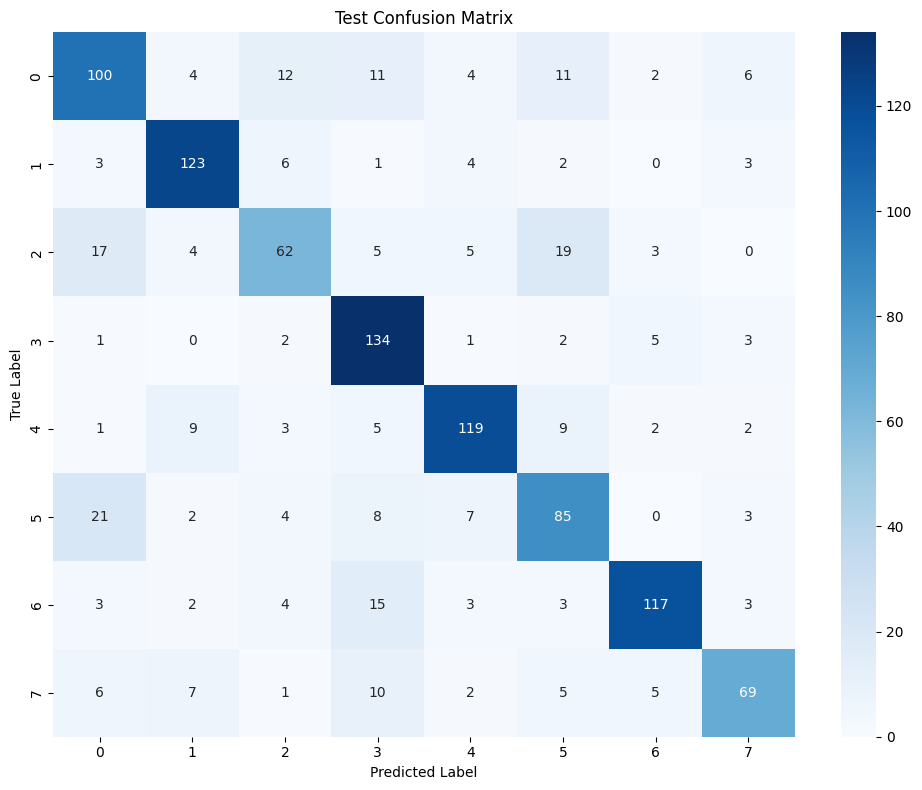

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7422018051147461     │
│        test_auroc         │    0.9526804685592651     │
│       test_f1_score       │    0.7339445948600769     │
│      test_precision       │    0.7418922781944275     │
│        test_recall        │    0.7327152490615845     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.7422018051147461,
  'test_f1_score': 0.7339445948600769,
  'test_auroc': 0.9526804685592651,
  'test_precision': 0.7418922781944275,
  'test_recall': 0.7327152490615845}]

In [7]:
trainer.test(model=lit_model, datamodule=garbage_classification_data)
